<a id="1.Summary"></a>
# 1.Summary

You will need to use the Penn Treebank corpus for this assignment. Four data fles are provided: train.txt,
train.5k.txt, valid.txt, and input.txt. You can use train.txt to train your models and use valid.txt for testing.
File input.txt can be used for a sanity check on whether the model produces coherent sequences of words for
unseen data with no next word.

<br>

<a id="2.Table of Contents"></a>
# 2.Table of Contents
<a href="#1.Summary">Click this Link back to Top</a>

<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Table of Contents">Table of Contents</a></li>
    <li><a href="#3.N-gram">N-gram</a></li>
    <ul>
       <li><a href="#3.1 Preprocess">3.1 Preprocess</a></li>
       <li><a href="#3.2 Bigram">3.2 Bigram</a></li> 
       <li><a href="#3.3 Trigram">3.3 Trigram</a></li>
       <li><a href="#3.4 Good Turing Smoothing">3.4 Good Turing Smoothing</a></li> 
       <li><a href="#3.5 Kneser-Ney Smoothing">3.5 Kneser-Ney Smoothing</a></li> 
       <li><a href="#3.6 Predict">3.6 Predict</a></li> 
       <li><a href="#3.7 Kneser-Ney N-gram Prediction">3.7 Kneser-Ney N-gram Prediction</a></li>  
    </ul>
    <li><a href="#4.RNN">RNN</a></li>
    <ul>
       <li><a href="#4.1 Initial Parameters">4.1 Initial Parameters</a></li>
       <li><a href="#4.2 Forward Pass">4.2 Forward Pass</a></li> 
       <li><a href="#4.3 Loss">4.3 Loss</a></li>
       <li><a href="#4.4 Traing Step">4.4 Traing Step</a></li> 
       <li><a href="#4.5 Perplexity">4.5 Perplexity</a></li> 
       <li><a href="#4.6 Predict Words">4.6 Predict Words</a></li>   
    </ul>
    <li><a href="#5.Unused Code">Unused Code</a></li>
</ol>

<br>

<a id="3.N-gram"></a>
# 3.N-gram
<a href="#1.Summary">Click this Link back to Top</a>

In [3]:
import tensorflow as tf

In [1]:
import re

import numpy as np 
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_transform as tft
import matplotlib.pyplot as plt

In [70]:
from nltk import ngrams
import nltk
import copy

<a id="3.1 Preprocess"></a>
## 3.1 Preprocess
<a href="#1.Summary">Click this Link back to Top</a>

Preprocess the train and validation data, build the vocabulary, tokenize, etc. Here is another concen, in our raw data, there are a lot of <unk> and punctuation. Sometimes

In [7]:
class preprocess(object):
    """
    This class contain read_file() and token() functions. In the future, maybe we can use main() to direct
    process and generate a new DataFrame with cleaned data
    """
    def __init__(self):
        """
        This function is used to transfer hyperparameters between functions in CLASS 
        """
        #self.test = test
        
    def read_file(self, path):
        """
        Provide local path and output a DataFrame with new column
        """
        df = pd.read_csv(path,names= ['test'])
        self.df = df
        #print(path)
        return df
        
    def token(self, df):
        """
        clean->tokenizer->sequence
        Arugs:
        -----
        df:array-like
            input a full
        """
        # create a new list to fill in clearned text
        clean_list=[]
        for i in range(len(df)):
            # using regix to only extract letters, other puncuation \n \t will not be included
            cleaned_data = re.sub(r'[^A-Za-z. ]', '', df['test'][i])
            # 
            clean_list.append(cleaned_data)
        #create a new column with cleaned data
        df['cleaned'] = clean_list
        
        #
        tokenizer = Tokenizer(oov_token="<OOV>")
        #transfor sentence to number vector
        tokenizer.fit_on_texts(df['cleaned'])
        # get the index of each indivudule word
        word_index = tokenizer.word_index
        
        #only choose most frequency 10,000 word_index and transfrom sentences 
        #with them into number vector like[564, 452, 23, 1]
        #the out of vocabulary wiht be give 1. Maximize number of texts_to_sequences()
        #will be 9999, which means the 10000th frequceny will 
        #not show in this sequcen
        sequences = tokenizer.texts_to_sequences(df['cleaned'])
        
        # ***********************Random Print Part***********************
        # random pick a row from sequnce
        random_num = np.random.randint(0,len(sequences))
        print(f"Random pick the {random_num}th from corpus sequence")
        print(f"Current vectorized sequnce is {sequences[random_num]}")
        print(f"Converted back to string:", " ".join(list(word_index.keys())[list(word_index.values()).index(i)] \
                                                     for i in sequences[random_num]))
        
        # ***********************Random Print Part***********************
        
        return sequences, word_index, df
    
    def main(self):
        path_input = "03_data/13_a3-data/input.txt" 
        path_train5k = "03_data/13_a3-data/train.5k.txt"
        path_train = "03_data/13_a3-data/train.txt"
        path_valid = "03_data/13_a3-data/valid.txt"
        df_input = read_file(path_input)
        seq, word_index,df = token(df_input)

<br>

<a id="3.2 Bigram"></a>
## 3.2 Bigram
<a href="#1.Summary">Click this Link back to Top</a>

In [19]:
def ngram(seq, word_index, df, grams=2):
    """
    Maunally put sequence transform to 2-grams sequence with one by one and inser 2-gram sequcen into 
    DataFrame with a new column ['bigram']
    
    Argus:
    -----
    seq:list
        sequence come from preprocess() function, which is tokenizer and sequence result. Each number represent
        a word by a int number
    
    word_index:index
        used to find mapping relation between sequence number and real word
    """
    # add DataFrame with a new column "sequence" and fill it with seq list
    df['sequence'] = seq
    # cereate a new empty column to contain bigram
    df['bigram'] = ""
    # change this column into changable type 'object'
    df['bigram'] = df['bigram'].astype('object')
    
    # j iterate through samples of seq/df
    for j in tqdm(range(len(seq))):
        # clear  ngram list to contain bigram list
        ngrams_list=[]
        # iterate through every element in one row list
        for i in range(len(seq[j])-grams):
            # create a new sub-list from i to i+grams, like [i:i+2]
            seq_bi = seq[j][i:i+grams]
#                print(seq_bi)
#                 if seq_bi not in ngrams.keys():
#                     ngrams[seq_bi] = []
            # add these sub-list into
            ngrams_list.append(seq_bi)
            #print(ngrams_list)
        # for one sell in df, insert with bigram list
        df.at[j,'bigram'] = ngrams_list
    return df

<br>

<a id="3.3 Trigram"></a>
## 3.3 Trigram
<a href="#1.Summary">Click this Link back to Top</a>

In [156]:
def ngram_nltk(df, num, col_num='cleaned'):
    """
    """
    # nltk.
    #n_grams_list = []
    df_copy = df.copy()
    df_copy['bigram_nltk'] = ""
    # change this column into changable type 'object'
    df_copy['bigram_nltk'] = df_copy['bigram_nltk'].astype('object')
    n_grams_list = []
    for idx,i in tqdm(enumerate(df_copy[col_num])):
        #print(idx)
        n_grams = ngrams(nltk.word_tokenize(str(i)), num)
        ngrams_str = [ ' '.join(grams) for grams in n_grams]
        for j in ngrams_str:
            n_grams_list.append(j)
        df_copy.loc[idx,'bigram_nltk'] = ngrams_str
    df_copy.loc['total', 'bigram_nltk'] = n_grams_list
    return df_copy

In [162]:
df_3 = ngram_nltk(df_input, 2)

3165it [00:00, 3800.49it/s]


<br>

<a id="3.4 Good Turing Smoothing"></a>
## 3.4 Good Turing Smoothing
<a href="#1.Summary">Click this Link back to Top</a>

In [120]:
def nltk_tri_pred(model, w1, w2):
    prob_sum = 0
    possible_next_w = defaultdict(lambda: 0)
    for i in model.samples():
        if i[0] == w1 and i[1] == w2: # given previous word
            prob_sum += model.prob(i)
#             print("{0}:{1}".format(i, model.prob(i)))
            possible_next_w[i[2]] = model.prob(i)
    return possible_next_w




# all_trigrams = ( ngram for sent in all_sents_tokens for ngram in ngrams(sent, 3, pad_left = True, pad_right = True))
# freq_dist = nltk.FreqDist(all_trigrams)
# gt_trigram = nltk.SimpleGoodTuringProbDist(freq_dist)
    

NameError: name 'all_sents_tokens' is not defined

<a id="3.5 Kneser-Ney Smoothing"></a>
## 3.5 Kneser-Ney Smoothing
<a href="#1.Summary">Click this Link back to Top</a>

In [ ]:
def nltk_tri_pred(model, w1, w2):
    prob_sum = 0
    possible_next_w = defaultdict(lambda: None)
    for i in model.samples():
        if i[0] == w1 and i[1] == w2: # given previous word
            prob_sum += model.prob(i)
#             print("{0}:{1}".format(i, model.prob(i)))
            possible_next_w[i[2]] = model.prob(i)
    return possible_next_w

# all_trigrams = ( ngram for sent in all_sents_tokens for ngram in ngrams(sent, 3, pad_left = True, pad_right = True))
# freq_dist = nltk.FreqDist(all_trigrams)
# kneser_ney = nltk.KneserNeyProbDist(freq_dist, discount=0.75)

w1,w2 = "said",'milton'
nltk_tri_pred(kneser_ney, w1, w2)


<a id="3.6 Predict"></a>
## 3.6 Predict
<a href="#1.Summary">Click this Link back to Top</a>

In [322]:
def predict_ngram(df, first_row):
    """
    This functino used only for predict bigram model
    
    Argus:
    ---
    df:ndarry-like
        This dataframe must come from preprocess() function, which means have ['cleaned'] column
    """
    #********************Build Unigram DataFrame***********************************
    #create a dictionary {key=word : value=probabilty}
    #create a DataFrame, index is words and column['value_cout', 'probabilty']
    #before we caculate bigram, we need cacualte unigram first
    df_unigram = ngram_nltk(df, 1, 'cleaned')
    # count the occurance times of very 
    unigram_series = pd.Series(df_unigram.loc['total','bigram_nltk']).value_counts()
    #create a new dataframe,which contain words itself and its cooresponding counts
    df_prob_uni = pd.DataFrame(unigram_series, index=unigram_series.index, columns=['value_counts'])
    # caculate the condition probabitlyf of indivudal words
    df_prob_uni['probability'] = df_prob_uni['value_counts'] / unigram_series.sum()
    #********************Build Unigram DataFrame***********************************
    
    
    #********************Build Bigram DataFrame***********************************
    # create bigram dataframe from ngram_nltk() fuction
    df_bigram = ngram_nltk(df, 2, 'cleaned')
    # count the time of very pair of two gram key pair
    bigram_series = pd.Series(df_bigram.loc['total','bigram_nltk']).value_counts()
    # create bigram dataframe with words pair as index. we need change index later
    df_prob_bi = pd.DataFrame(bigram_series.index, \
                          index=bigram_series.index, \
                          columns=['bigram_pairs'])
    # create a new column with his word pair, next step we need change index to numercial
    df_prob_bi['value_counts'] = bigram_series
    # create a new column for ward pair, this is conditinal probability
    df_prob_bi['probability'] = df_prob_bi['value_counts'] / bigram_series.sum()
    #extract two words into split column, we need use i_1 and i to caculate bigram probabilty
    for i in df_prob_bi['bigram_pairs']:
        #split bigram word pair into two column
        m,n = df_prob_bi['bigram_pairs'][i].split(' ')
        df_prob_bi.loc[i, 'First(i-1)'] = m
        df_prob_bi.loc[i, 'Second(i)'] = n
    # caculate row and column
    m, n = df_prob_bi.shape
    # change index into numercial value
    df_prob_bi.index = np.arange(0, m)
    #********************Build Bigram DataFrame***********************************
    
    
    #*********************Cacualte Next Word****************************
    #p(w_i | w_i-1) = C(w_i-1, w_i) / c(w_i-1)
    for i in range(m):
        c_bigram = df_prob_bi.loc[i,'probability']
        #select the probabilty from unigram index == first word in bigram model
        c_w_i_1 = df_prob_uni.loc[df_prob_uni.index == df_prob_bi.loc[i,'First(i-1)'], 'probability']
        df_prob_bi.loc[i, 'joint_prob'] = float(c_bigram / c_w_i_1)
    #     df_prob_bi.loc[i, 'joint_prob'] = 0
    #*********************Cacualte Next Word****************************
    
    
    #***********************Display Part*******************************
    for i in range(30):
        sentence = df_input.loc[i, 'cleaned']
        word = sentence.split(' ')[-2]
        #print(word)
        next_prob = df_prob_bi.loc[df_prob_bi['First(i-1)']==word, 'joint_prob'].max()
        #print(next_prob)
    #     next_word = df_prob_bi.loc[df_prob_bi['joint_prob']==next_prob, 'Second(i)'].iloc[0]
        try:
            next_word = df_prob_bi.loc[df_prob_bi['joint_prob']==next_prob, 'Second(i)'].iloc[0]
        except:
            next_word = "OUT OF VOCABULARY"
        print(f"SENTCEN: {sentence}, PREDICT WORD: {next_word}")
    #***********************Display Part*******************************
    
    
    return df_prob_bi

In [323]:
predict_ngram(df_input, first_row = 30)

3165it [00:00, 3948.39it/s]
3165it [00:00, 3402.12it/s]


SENTCEN: but while the new york stock exchange did nt fall , PREDICT WORD: the
SENTCEN: some circuit breakers installed after the october N crash failed , PREDICT WORD: to
SENTCEN: the N stock specialist firms on the big board floor , PREDICT WORD: market
SENTCEN: big investment banks refused to step up to the plate , PREDICT WORD: OUT OF VOCABULARY
SENTCEN: heavy selling of standard  poor s stock index futures , PREDICT WORD: said
SENTCEN: seven big board stocks ual amr bankamerica walt disney capital , PREDICT WORD: of
SENTCEN: once again the specialists were not able to handle the , PREDICT WORD: unk
SENTCEN: unk james unk chairman of specialists henderson brothers inc. it , PREDICT WORD: s
SENTCEN: when the dollar is in a unk even central banks , PREDICT WORD: the
SENTCEN: speculators are calling for a degree of liquidity that is , PREDICT WORD: the
SENTCEN: many money managers and some traders had already left their , PREDICT WORD: the
SENTCEN: then in a unk plunge the dow jones i

,bigram_pairs,value_counts,probability,First(i-1),Second(i),joint_prob
0,of the,187,0.006608,of,the,0.256686
1,N N,167,0.005902,N,N,0.243673
2,the unk,167,0.005902,the,unk,0.085291
3,in the,147,0.005195,in,the,0.261507
4,unk unk,134,0.004735,unk,unk,0.080884
...,...,...,...,...,...,...
17741,most competitive,1,0.000035,most,competitive,0.019170
17742,a rough,1,0.000035,a,rough,0.001540
17743,will get,1,0.000035,will,get,0.007668
17744,growing official,1,0.000035,growing,official,0.123539


<br>

<a id="3.7 Kneser-Ney N-gram Prediction"></a>
## 3.7 Kneser-Ney N-gram Prediction
<a href="#1.Summary">Click this Link back to Top</a>

In [5]:
if __name__=="__main__":
    path_input = "03_data/13_a3-data/input.txt" 
    path_train5k = "03_data/13_a3-data/train.5k.txt"
    path_train = "03_data/13_a3-data/train.txt"
    path_valid = "03_data/13_a3-data/valid.txt"
    pre = preprocess()
    df_input = pre.read_file(path_input)
    df_train5k = pre.read_file(path_train5k)
    df_train = pre.read_file(path_train)
    df_valid = pre.read_file(path_valid)
    seq, word_index,df = pre.token(df_input)
    #df = ngram(seq, word_index, df, grams=2)

Random pick the 252th from corpus sequence
Current vectorized sequnce is [205, 9, 456, 12, 1008, 2450, 6, 533, 3, 427]
Converted back to string: quantum s lot is mostly tied to polyethylene unk used


<a id="4.RNN"></a>
# 4.RNN
<a href="#1.Summary">Click this Link back to Top</a>

<a id="4.1 Initial Parameters"></a>
## 4.1 Initial Parameters
<a href="#1.Summary">Click this Link back to Top</a>

In [56]:
#max lengh of vocaubulary 
# vocab_size = 11
#embedding layer dimension
# embedding_dim = 32
#unit of SimpleRNN
#rnn_units = 64

<a id="4.2 Forward Pass"></a>
## 4.2 Forward Pass
<a href="#1.Summary">Click this Link back to Top</a>

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
# vocab_size = 11
# embedding_dim = 32
# rnn_units = 64
# BATCH_SIZE = 16
# model_1 = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [ ]:
def rnn_model():
    # before we input data, we need set up seq_length and padding our data
    # seq_length should use plot to decide boundary

    # ********************************************************
    # for each input sequence, maybe we need right shift one word
    # ********************************************************

    seq_length =11
    #input_layer1 = layers.Input(shape=seq_length)
    # first layer is Embedding, output_idm is number of units/cells
    emb_layer2 = layers.Embedding(input_dim = seq_length, output_dim = 32)(input_layer1)
    # second layer is RNN
    rnn_layer3 = layers.SimpleRNN(units = 32, activation='relu', return_sequences=True)(emb_layer2)
    # rnn_layer2 = layers.GRU(units = 32, activation='relu')(input_layer1)
    # only contain one hidden layer
    output_layer4 = layers.Dense(units=seq_length)(rnn_layer3)
    model_1 = Model(inputs = input_layer1, outputs = output_layer4)


    model_1.summary()
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    # model_rnn = 
    
    return model_1

In [48]:
def lstm_model(total_words, max_sequence_len, emb_dim=1024):
    """
    
    """
    # before we input data, we need set up total_words and padding our data
    # total_words should use plot to decide boundary

    # ********************************************************
    # for each input sequence, maybe we need right shift one word
    # ********************************************************

    #total_words =11
    #input_layer1 = layers.Input(shape=total_words)
    # first layer is Embedding, output_idm is number of units/cells
    emb_layer2 = layers.Embedding(input_dim = total_words, \
                                  output_dim = emb_dim, \
                                  input_length=max_sequence_len-1)
    # second layer is RNN
#     lstm_layer3 = layers.LSTM(units = 2048, activation='relu', return_sequences=True)(emb_layer2)
    lstm_layer3 = layers.Bidirectional(layers.LSTM(2048))(emb_layer2)
    # rnn_layer2 = layers.GRU(units = 32, activation='relu')(input_layer1)
    # only contain one hidden layer
    output_layer4 = layers.Dense(units=total_words)(lstm_layer3)
    model = Model(inputs = emb_layer2, outputs = output_layer4)
    adam = tf.keras.optimizers.Adam(lr=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    # model_rnn = 
    # history = model.fit(xs, ys, epochs=10, verbos=1 )
    return model

In [89]:
def lstm_mod(total_words, max_sequence_len):
    print(total_words)
    model = Sequential()
    model.add(layers.Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(layers.Bidirectional(layers.LSTM(150)))
    model.add(layers.Dense(total_words, activation='softmax'))
    adam = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    #earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    model.summary()
    return model

In [88]:
total_words

9868

In [91]:
max_sequence_len

12

In [90]:
model_3 = lstm_mod(total_words, max_sequence_len)

9868
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 11, 100)           986800    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 300)               301200    
_________________________________________________________________
dense_8 (Dense)              (None, 9868)              2970268   
Total params: 4,258,268
Trainable params: 4,258,268
Non-trainable params: 0
_________________________________________________________________


In [55]:
# history = model_3.fit(xs, ys, epochs=10, verbose=1)

Train on 28337 samples
Epoch 1/10
28337/28337 [==============================] - 24s 857us/sample - loss: 6.4521 - accuracy: 0.1000
Epoch 2/10
28337/28337 [==============================] - 18s 648us/sample - loss: 5.5810 - accuracy: 0.1514
Epoch 3/10
28337/28337 [==============================] - 18s 653us/sample - loss: 4.8539 - accuracy: 0.1825
Epoch 4/10
28337/28337 [==============================] - 19s 654us/sample - loss: 4.1897 - accuracy: 0.2221
Epoch 5/10
28337/28337 [==============================] - 19s 670us/sample - loss: 3.6203 - accuracy: 0.2699- loss: 3.6192 - accuracy: 0.
Epoch 6/10
28337/28337 [==============================] - 19s 662us/sample - loss: 3.1579 - accuracy: 0.3242
Epoch 7/10
28337/28337 [==============================] - 19s 660us/sample - loss: 2.8197 - accuracy: 0.3682
Epoch 8/10
28337/28337 [==============================] - 18s 652us/sample - loss: 2.5343 - accuracy: 0.4109
Epoch 9/10
28337/28337 [==============================] - 19s 655us/sample -

In [57]:
# from IPython.display import SVG
# from tensorflow.keras.utils import model_to_dot, plot_model

# SVG(plot_model(model_1,dpi=60,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

# dot_img_file = '04_images/14_model_1.png'
# # plot_model(model_1, to_file=dot_img_file, show_shapes=True)
# plot_model(model_1, to_file='04_images/15_model_96DPI.svg')

<a id="4.3 Loss"></a>
## 4.3 Loss
<a href="#1.Summary">Click this Link back to Top</a>

<a id="4.4 Traing Step"></a>
## 4.4 Traing Step
<a href="#1.Summary">Click this Link back to Top</a>

In [72]:
if __name__=="__main__":
    path_input = "03_data/13_a3-data/input.txt" 
    path_train5k = "03_data/13_a3-data/train.5k.txt"
    path_train = "03_data/13_a3-data/train.txt"
    path_valid = "03_data/13_a3-data/valid.txt"
    
    #call Class preprocess()
    pre = preprocess()
    df_input = pre.read_file(path_input)
    df_train5k = pre.read_file(path_train5k)
    df_train = pre.read_file(path_train)
    df_valid = pre.read_file(path_valid)
    seq_input, word_index_input,df_input = pre.token(df_input)
    seq_train5k, word_index_train5k,df_train5k = pre.token(df_train5k)
    seq_train, word_index_train,df_train = pre.token(df_train)
    seq_valid, word_index_valid,df_valid = pre.token(df_input)
    #df = ngram(seq, word_index, df, grams=2)

Random pick the 733th from corpus sequence
Current vectorized sequnce is [7, 141, 14, 2, 33, 9, 77, 111, 12, 2690]
Converted back to string: a spokesman said the company s first quarter is historically
Random pick the 4844th from corpus sequence
Current vectorized sequnce is [85, 43, 936, 1223, 209, 731, 305, 882, 3, 436, 23, 1106, 53, 5, 2, 3, 1092, 63, 92, 8, 936, 34, 8, 2, 589, 632]
Converted back to string: last year pennsylvania supreme court justice john p unk called mr okicki one of the unk judges not only in pennsylvania but in the united states
Random pick the 21347th from corpus sequence
Current vectorized sequnce is [68, 2, 947, 516, 67, 926, 186, 4447, 22, 126]
Converted back to string: if the situation changes i ll get stuck with them
Random pick the 266th from corpus sequence
Current vectorized sequnce is [45, 3, 12, 958, 3, 7, 3, 534, 19, 2458]
Converted back to string: one unk is george unk a unk analyst at oppenheimer


In [72]:
df_train.shape

(42068, 2)

In [96]:
   
#     # seq_length is the max length of these questions
#     seq_length = 11
#     # maintain the sentence into same length
#     # padded = pad_sequences(sequences)
#     # If you want zero at the end, using padding='post'
#     padded = pad_sequences(seq, padding='post', maxlen=seq_length, truncating='post')

    # ************************************Train Data*****************************
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['cleaned'])
total_words = len(word_index_train) + 1

# we will populate this with sub sequence with 
input_sequences = []
for line in df_train['cleaned']:
    #texts_to sequnce will create a list, so it will be list nested into another list. So we need [0] to extarct
    #provide current token for current line according to tokenizer.fit_on_text() dictonary
    token_list = tokenizer.texts_to_sequences([line])[0]
    token_list = [i+1 for i in token_list ]
    #print(token_list)
    for i in range(len(token_list)-1, len(token_list)):
        #generate a sequence contain from first one to last one
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences, because we need last one as a non-zero real words, so we add zero in the front
# we can see out very last word as Y and other, from first to end before Y as "input_X"
max_sequence_len = max([len(x) for x in input_sequences])
#print(max_sequence_len)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs_train, labels = input_sequences[:,:-1],input_sequences[:,-1]
# Finally we want our our Y to be catigorical and become one-hot encoding
# Here is a odd "+1", because I add 1 tiwice, first is to match index for <oov> missing, 
# second is len(tokenizer.word_index) = 4016, but len(word_index) = 4017
ys_train = tf.keras.utils.to_categorical(labels, num_classes=total_words, dtype='uint64')

# m = len(labels)
# y_mapped=np.zeros((m, total_words))
# for i in range(0,m):
#     #print(i)
#     y_mapped[i, labels[i]]=1;
# ************************************Train Data*****************************


model_3 = lstm_mod(total_words, max_sequence_len)
history = model_3.fit(xs_train, ys_train, epochs=30,verbose=1)

9868
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 79, 100)           986800    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 300)               301200    
_________________________________________________________________
dense_10 (Dense)             (None, 9868)              2970268   
Total params: 4,258,268
Trainable params: 4,258,268
Non-trainable params: 0
_________________________________________________________________
Train on 42068 samples
Epoch 1/30
42068/42068 [==============================] - 69s 2ms/sample - loss: 6.4533 - accuracy: 0.1913
Epoch 2/30
42068/42068 [==============================] - 66s 2ms/sample - loss: 5.1368 - accuracy: 0.2625
Epoch 3/30
42068/42068 [==============================] - 65s 2ms/sample - loss: 4.3004 - accuracy: 0.2954
Epoch 4/30
42068/42068 [

In [101]:
# !mkdir -p saved_model_3
model_3.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


In [103]:
model_3.save("my_h5_model_3.h5")

In [107]:
    
# ************************************Test Data********************************
tokenizer.fit_on_texts(df_train['cleaned'])
total_words = len(word_index_train) + 1

# we will populate this with sub sequence with 
input_sequences = []
for line in df_valid['cleaned']:
    #texts_to sequnce will create a list, so it will be list nested into another list. So we need [0] to extarct
    #provide current token for current line according to tokenizer.fit_on_text() dictonary
    token_list = tokenizer.texts_to_sequences([line])[0]
    token_list = [i+1 for i in token_list ]
    #print(token_list),only extract the last full sequence
    for i in range(len(token_list)-1, len(token_list)):
        #generate a sequence contain from first one to last one
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences, because we need last one as a non-zero real words, so we add zero in the front
# we can see out very last word as Y and other, from first to end before Y as "input_X"
max_sequence_len = max([len(x) for x in input_sequences])
#print(max_sequence_len)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=80, padding='pre'))

# create predictors and label
xs_test, labels = input_sequences[:,:-1],input_sequences[:,-1]
# Finally we want our our Y to be catigorical and become one-hot encoding
# Here is a odd "+1", because I add 1 tiwice, first is to match index for <oov> missing, 
# second is len(tokenizer.word_index) = 4016, but len(word_index) = 4017
ys_test = tf.keras.utils.to_categorical(labels, num_classes=total_words)




model_3.evaluate(xs_test, ys_test)

3165/3165 [==============================] - 3s 985us/sample - loss: 18.7225 - accuracy: 0.0562


[18.722465580221602, 0.056240126]

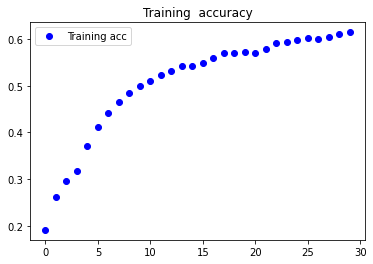

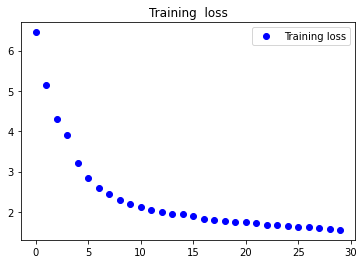

In [112]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training  accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training  loss')
plt.legend()

plt.show()

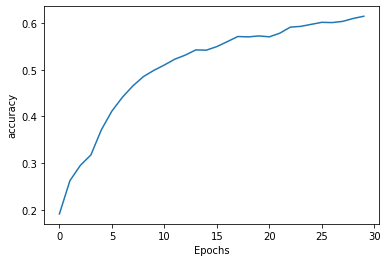

In [113]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
plot_graphs(history, 'accuracy')

<br>

<a id="4.5 Perplexity"></a>
## 4.5 Perplexity
<a href="#1.Summary">Click this Link back to Top</a>

In [10]:
def K_perp(y_true, y_pred):
    CE = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.exp(K.mean(CE))
    return perplexity


from sklearn.metrics import log_loss 
def np_perp(y_true, y_pred):
    CE = log_loss(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    perplexity = np.exp(np.mean(CE))
    return perplexity

<a id="4.6 Predict Words"></a>
## 4.6 Predict Words
<a href="#1.Summary">Click this Link back to Top</a>

In [119]:
for line in df_input['cleaned'][0:30]:
    token_list = tokenizer.texts_to_sequences([line])[0]
    token_list = pad_sequences([token_list], maxlen=79, padding='pre')
    predicted = model_3.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    line += " " + "[" + output_word + "]"
    print(f"predict setence is {line}")

predict setence is but while the new york stock exchange did nt fall  [longest]
predict setence is some circuit breakers installed after the october N crash failed  [remember]
predict setence is the N stock specialist firms on the big board floor  [of]
predict setence is big investment banks refused to step up to the plate  [n]
predict setence is heavy selling of standard  poor s stock index futures  [n]
predict setence is seven big board stocks ual amr bankamerica walt disney capital  [july]
predict setence is once again the specialists were not able to handle the  [spent]
predict setence is unk james unk chairman of specialists henderson brothers inc. it  [significant]
predict setence is when the dollar is in a unk even central banks  [n]
predict setence is speculators are calling for a degree of liquidity that is  [also]
predict setence is many money managers and some traders had already left their  [defense]
predict setence is then in a unk plunge the dow jones industrials in  [law

<a id="5.Unused Code"></a>
# 5.Unused Code
<a href="#1.Summary">Click this Link back to Top</a>

In [ ]:
for i in seq[50]:
    print(i)

In [ ]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6]])

In [ ]:
np.concatenate((a, b), axis=0)

In [ ]:
list(mydict.keys())[list(mydict.values()).index(16)]

In [ ]:
list(word_index.keys())[list(word_index.values()).index(156)]

In [ ]:
word_index.items()

In [ ]:
for i in 

In [ ]:
for word, idx in word_index.items():
    if idx == 156:
        print(word)

In [ ]:
seq[0]

In [ ]:
len_list=[]
for i in seq:
    len_list.append(len(i))

In [ ]:
plt.plot(np.arange(len(len_list)),len_list)

In [ ]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

In [56]:
def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]
 
data = 'A class is a blueprint for the object.'
 
print("1-gram: ", extract_ngrams(data, 2))

1-gram:  ['A class', 'class is', 'is a', 'a blueprint', 'blueprint for', 'for the', 'the object', 'object .']


In [ ]:
from collections import Counter, defaultdict

# Create a placeholder for model
model = defaultdict(lambda: defaultdict(lambda: 0))

# Count frequency of co-occurance  
for sentence in df_input:
    for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
        model[(w1, w2)][w3] += 1
 
# Let's transform the counts to probabilities
for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count


In [122]:
def get2GramSentence(sentence, n = 1):
    for i in range(n):
        print(sentence)
        # Find Next word
        word = next((element[0][1] for element in gram2 if element[0][0] == word), None)
        if not word:
            break

word = df_input["cleaned"][0:30]
print("Start sentence: %s" % word)

print("2-gram sentence: \"",)
get2GramSentence(word, 20)

Start sentence: 0     but while the new york stock exchange did nt f...
1     some circuit breakers installed after the octo...
2     the N stock specialist firms on the big board ...
3     big investment banks refused to step up to the...
4     heavy selling of standard  poor s stock index ...
5     seven big board stocks ual amr bankamerica wal...
6     once again the specialists were not able to ha...
7     unk james unk chairman of specialists henderso...
8       when the dollar is in a unk even central banks 
9     speculators are calling for a degree of liquid...
10    many money managers and some traders had alrea...
11    then in a unk plunge the dow jones industrials...
12    unk trading accelerated to N million shares a ...
13         at the end of the day N million shares were 
14    the dow s decline was second in point terms only 
15    in percentage terms however the dow s dive was...
16    shares of ual the parent of united airlines we...
17    wall street s takeoverstoc

NameError: name 'xrange' is not defined